In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

plt.rcParams["figure.figsize"] = [10, 5]

df=pd.read_csv('app/model/data/df_file.csv')

df['Text'] = df['Text'].apply(lambda x:x.replace('\n',''))
df.head()

,Text,Label
0,Budget to set scene for election Gordon Brown...,0
1,Army chiefs in regiments decision Military ch...,0
2,Howard denies split over ID cards Michael How...,0
3,Observers to monitor UK election Ministers wi...,0
4,Kilroy names election seat target Ex-chat sho...,0


In [15]:
df.shape

(2225, 2)

In [16]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import warnings

In [17]:
# Duplicates
duplicated = df.duplicated().sum()
nulls = df.isnull().sum().to_frame().rename(columns = {0:'count'})

print(f"Size before removing duplicated and null items: {len(df)}\n")
print(f"Duplicates: {duplicated} items ({round(100 * duplicated/len(df), 5)}%)")
print("\nEmpty slots:")
print(f"Text: {nulls['count']['Text']}; Label: {nulls['count']['Label']}")

df.drop_duplicates(ignore_index = True, inplace=True)

print(f"\nSize after removing duplicated and null items: {len(df)}\n")

Size before removing duplicated and null items: 2225

Duplicates: 98 items (4.40449%)

Empty slots:
Text: 0; Label: 0

Size after removing duplicated and null items: 2127



In [18]:
categories = {
    0: "Politics",
    1: "Sport",
    2: "Technology",
    3: "Entertainment",
    4: "Business",
}

In [19]:
freq = df['Label'].value_counts()

for label, count in freq.items():
     print(f"{categories[label]}: {count} items ({100 * round(count/df['Label'].count(), 2)}%)")

Sport: 505 items (24.0%)
Business: 503 items (24.0%)
Politics: 403 items (19.0%)
Entertainment: 369 items (17.0%)
Technology: 347 items (16.0%)


In [20]:
import spacy

nlp = spacy.load("en_core_web_sm")

In [21]:
from app.model.model import preprocess
df['prep_text'] = df['Text'].apply(preprocess)
df.head()

,Text,Label,prep_text
0,Budget to set scene for election Gordon Brown...,0,budget to set scene for election Gordon Brown ...
1,Army chiefs in regiments decision Military ch...,0,army chief in regiment decision Military chief...
2,Howard denies split over ID cards Michael How...,0,Howard deny split over ID card Michael Howard ...
3,Observers to monitor UK election Ministers wi...,0,observer to monitor UK election Ministers will...
4,Kilroy names election seat target Ex-chat sho...,0,kilroy name election seat target Ex chat show ...


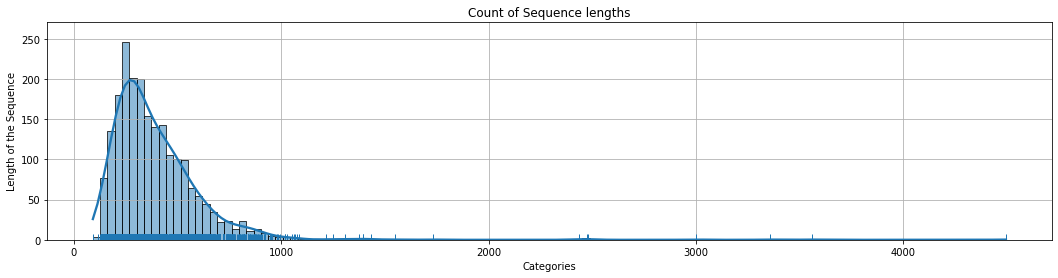

In [22]:
seq_len = []

for txt in df.prep_text:
    seq_len.append(len(txt.split()))
    
plt.figure(figsize = (18, 4))
sns.histplot(seq_len, kde = True, line_kws = {'linewidth': 2.3})
sns.rugplot(seq_len)
plt.title('Count of Sequence lengths')
plt.xlabel('Categories')
plt.ylabel('Length of the Sequence')
plt.grid(True)
plt.show()

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5,ngram_range=(1, 2), stop_words='english')

# Transform preprocessed text into TF-IDF features
features = vectorizer.fit_transform(df['prep_text']).toarray()

In [24]:
from sklearn.model_selection import train_test_split

X = features
y = df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

print(f'Rows used in training: {len(X_train)}')
print(f'Rows used in evaluation: {len(X_test)}')

Rows used in training: 1701
Rows used in evaluation: 426


In [25]:
y_train_vals = []
train_labels = []

y_test_vals = []
test_labels = []

for i in range(len(y_train.unique())):
    y_train_vals.append(round(y_train.value_counts()[i]/len(y_train) * 100,2))
    train_labels.append(y_train.unique()[i])

for i in range(len(y_test.unique())):
    y_test_vals.append(round(y_test.value_counts()[i]/len(y_test) * 100,2))
    test_labels.append(y_test.unique()[i])

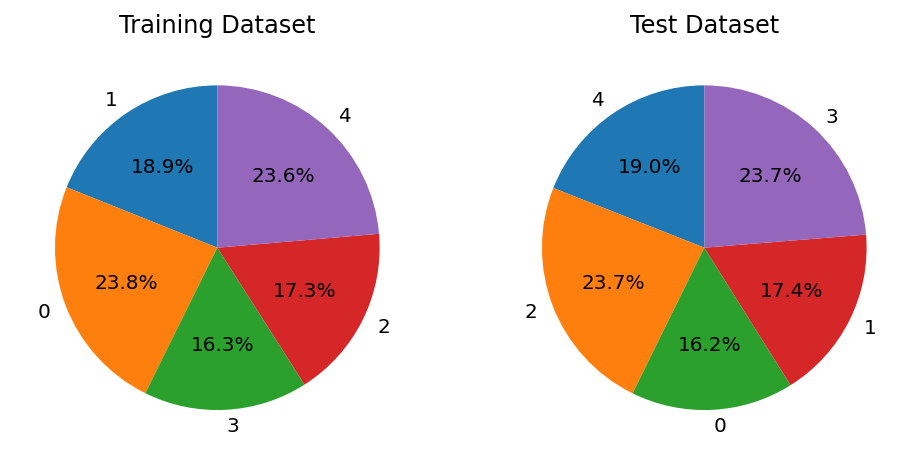

In [26]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=144)

# Plot for training dataset
axs[0].pie(y_train_vals, labels=train_labels, autopct='%1.1f%%', startangle=90)
axs[0].set_title('Training Dataset')

# Plot for test dataset
axs[1].pie(y_test_vals, labels=test_labels, autopct='%1.1f%%', startangle=90)
axs[1].set_title('Test Dataset')

plt.show()

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

classifiers = {
    "LogisiticRegression": {'model':LogisticRegression()},
    "DecisionTreeClassifier": {'model':DecisionTreeClassifier()},
    "Random Forest Classifier": {'model':RandomForestClassifier()},
}

categories = {'Politics':0,'Sport':1, 'Technology':2,'Entertainment':3,'Business':4}

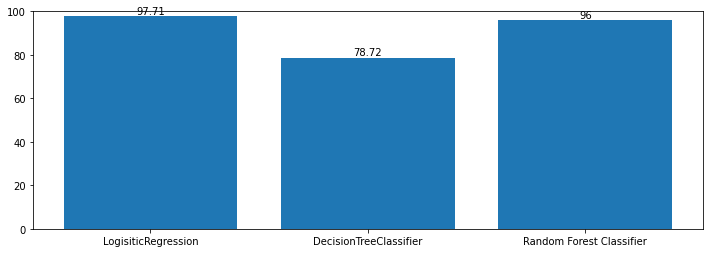

In [28]:
from sklearn.model_selection import cross_val_score

scores = {}

for key, alg in classifiers.items():
    try:
        alg['model'].fit(X_train, y_train, 
                early_stopping_rounds=10,
                eval_metric='merror',
                eval_set=[(X_test, y_test)])
    except TypeError:
        alg['model'].fit(X_train, y_train)
        
    training_score = cross_val_score(alg['model'], X_train, y_train, cv=5, scoring='accuracy') 
    scores[key] = round(training_score.mean() * 100, 2) 
    
fig, ax = plt.subplots(figsize=(12, 4))
bars = ax.bar(scores.keys(), scores.values())
ax.bar_label(bars, label_type="edge")
plt.ylim(0, 100)
plt.show()

In [29]:
from sklearn import metrics

classifiers[max(scores, key=scores.get)]['model'].fit(X_train, y_train)
y_pred = classifiers['LogisiticRegression']['model'].predict(X_test)

print('Metrics (Logistic Regression)\n')
print(metrics.classification_report(y_test, y_pred, target_names= categories.keys()))

Metrics (Logistic Regression)

               precision    recall  f1-score   support

     Politics       0.97      0.96      0.97        81
        Sport       0.99      1.00      1.00       101
   Technology       0.99      0.97      0.98        69
Entertainment       0.99      0.99      0.99        74
     Business       0.98      0.99      0.99       101

     accuracy                           0.98       426
    macro avg       0.98      0.98      0.98       426
 weighted avg       0.98      0.98      0.98       426

